# Test Neurolearn Functionality

In [2]:
from pyneurovault import api
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import nibabel as nb
import numpy as np
import pickle
from nltools.analysis import Predict, apply_mask, Roc
%matplotlib inline

outfolder = "/Users/lukechang/Downloads/nv_tmp"


Couldn't import dot_parser, loading of dot files will not be possible.


# Download Pain Images

In [13]:
tic = time.time() #Start Timer

# Pain Collection
collection = 504

# Will extract all collections and images in one query to work from
nv = api.NeuroVault()

# Download all images to file
standard = os.path.join(os.path.dirname(api.__file__),'data','MNI152_T1_2mm_brain.nii.gz')
nv.download_images(dest_dir = outfolder,target=standard, collection_ids=[collection],resample=False)

# Create Variables
collection_data = nv.get_images_df().ix[nv.get_images_df().collection_id == collection,:].reset_index()
img_index = sorted((e,i) for i,e in enumerate(collection_data.file))
index = [x[1] for x in img_index]
img_file = [x[0] for x in img_index]

dat = nb.funcs.concat_images([os.path.join(outfolder,'original',str(x) + '.nii.gz') for x in collection_data.image_id[index]])
holdout = [int(x.split('_')[-2]) for x in img_file]
heat_level = [x.split('_')[-1].split('.')[0] for x in img_file]
Y_dict = {'High':3,'Medium':2,'Low':1}
Y = np.array([Y_dict[x] for x in heat_level])

# Pickle for later use
# Saving the objects:
with open(os.path.join(outfolder,'Pain_Data.pkl'), 'w') as f:
    pickle.dump([dat,holdout,Y], f)

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

Extracting NeuroVault collections meta data...
Found 238 results.
Extracting NeuroVault images meta data...
Found 6302 results.
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=1000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=2000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=3000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=4000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=5000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=6000
NeuroVault Object (nv) Includes <nv.images><nv.collections>
Elapsed: 172.62 seconds


# Load Pickled Data

In [4]:
tic = time.time() #Start Timer

# Getting back the objects:
with open(os.path.join(outfolder,'Pain_Data.pkl')) as f:
    dat, holdout, Y = pickle.load(f)
print 'Load Pickled File - Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


Load Pickled File - Elapsed: 24.17 seconds


# Run Prediction

overall Root Mean Squared Error: 0.98
overall Correlation: 0.55
Total Elapsed: 7.30 seconds


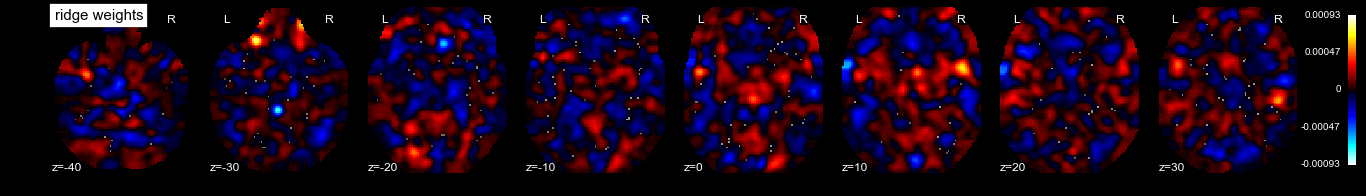

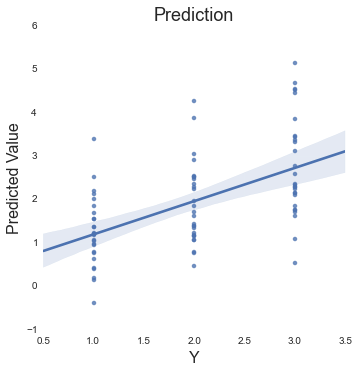

In [5]:
tic = time.time() #Start Timer

## Test Prediction with kfold xVal
# SVR
# negvneu = Predict(dat,Y,algorithm='svr',subject_id = holdout, output_dir=outfolder, cv_dict = {'kfolds':5}, **{'kernel':"linear"})
# negvneu = Predict(dat,Y,algorithm='svr',subject_id = holdout, output_dir=outfolder, cv_dict = {'loso':holdout}, **{'kernel':"linear"})
# negvneu.predict()
# print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

# Ridge
negvneu = Predict(dat,Y,algorithm='ridge',subject_id = holdout, output_dir=outfolder, cv_dict = {'kfolds':5})
negvneu.predict()

# # Principal Components Regression
# negvneu = Predict(dat,Y,algorithm='pcr',subject_id = holdout, output_dir=outfolder, cv_dict = {'kfolds':5})
# negvneu.predict()
print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


## Apply Mask

Elapsed: 44.62 seconds


/usr/local/lib/python2.7/site-packages/nilearn/signal.py:50: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


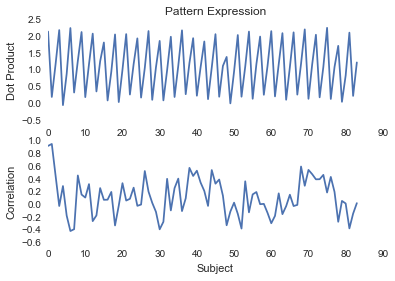

In [8]:
tic = time.time() #Start Timer

# Load data using nibabel
pines = nb.load(os.path.join(outfolder, 'ridge_weightmap.nii.gz'))

pexpd = apply_mask(data=dat, weight_map=pines, output_dir=outfolder, method='dot_product', save_output=True)
pexpc = apply_mask(data=dat, weight_map=pines, output_dir=outfolder, method='correlation', save_output=True)

plt.subplot(2, 1, 1)
plt.plot(pexpd)
plt.title('Pattern Expression')
plt.ylabel('Dot Product')

plt.subplot(2, 1, 2)
plt.plot(pexpc)
plt.xlabel('Subject')
plt.ylabel('Correlation')

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


## ROC Analysis

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.84
Accuracy SE:        0.11
Accuracy p-value:   0.00
Sensitivity:        0.93
Specificity:        0.75
AUC:                0.88
PPV:                0.79
------------------------
[ 1.          1.          1.         ...,  0.03571429  0.03571429
  0.03571429]
Total Elapsed: 1.30 seconds


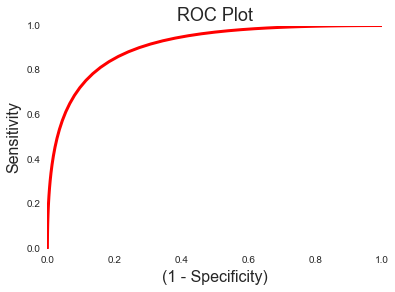

In [7]:
tic = time.time() #Start Timer

# Create Variables
negvneu.yfit
include = (negvneu.Y==3) | (negvneu.Y==1)
input_values = negvneu.yfit[include]
binary_outcome = negvneu.Y[include]
binary_outcome = binary_outcome==3

# Single-Interval
roc = Roc(input_values=input_values, binary_outcome=binary_outcome)
roc.plot()
roc.summary()

print roc.tpr
roc.accuracy

# # Forced Choice 
# roc_fc = Roc(input_values=input_values, binary_outcome=binary_outcome, forced_choice=True)
# roc_fc.plot()
# roc_fc.summary()

print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

In [7]:
from nilearn.input_data import NiftiMasker
mask = nb.load('/Users/lukechang/Github/neurolearn/nltools/resources/MNI152_T1_2mm_brain_mask_dil.nii.gz')
nifti_masker = NiftiMasker(mask_img=mask)
pcr = nb.load(os.path.join(outfolder,'pcr_weightmap.nii.gz'))
ridge = nb.load(os.path.join(outfolder,'ridge_weightmap.nii.gz'))
pcr_mask = nifti_masker.fit_transform(pcr)
ridge_mask = nifti_masker.fit_transform(ridge)
np.corrcoef(pcr_mask,ridge_mask)

<nltools.analysis.Predict instance at 0x107dfd9e0>